In [1]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 85.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.4 requires fastcore<1.9,>=1.8.0, but you have fastcore 1.11.3 which is incompatible.


In [2]:
!git clone https://github.com/Aman-Yadav-PY/Vision-Transformer-Model.git
import os
os.chdir("Vision-Transformer-Model")

Cloning into 'Vision-Transformer-Model'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 129 (delta 64), reused 83 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (129/129), 3.69 MiB | 34.98 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [3]:
import numpy as np
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.io import decode_image
from torchvision.datasets import Food101
from torchvision.transforms import Compose, v2

from sklearn.model_selection import train_test_split
from modelpipe import HybridVitNet

from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
ds_path = "/kaggle/input/food101"
generator = torch.Generator(device='cpu')

image_size = 224, 224
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available Device: ", device)

Available Device:  cuda


In [6]:
normalizer = v2.Normalize(mean=[0.5567, 0.4381, 0.3198], std=[0.2591, 0.2623, 0.2633])   

train_transform = v2.Compose([v2.Resize(image_size), v2.ToDtype(torch.float32, scale=True), normalizer])

test_transform = v2.Compose([v2.Resize(image_size), v2.ToDtype(torch.float32, scale=True), normalizer])

trainset = Food101(ds_path,split='train', transform=train_transform, loader=decode_image)
testset = Food101(ds_path, split='test', transform=test_transform, loader=decode_image)

In [7]:
def random_tt_split(dataset, factor):
    length= int(factor* len(dataset))
    remaining = len(dataset) - length
    datasetA, datasetB = random_split(dataset, [length, remaining], generator=generator)
    print("Splited Datset Lengths:", (len(datasetA), len(datasetB)))
    return datasetA,datasetB


def data_loader(dataset, shuffle=True, batch_size=batch_size, num_workers=2, prefetch_factor=8, pin_memory=True):
    return DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=2, prefetch_factor=2, pin_memory=True)

In [8]:
def get_subset(dataset, test_size, s_test_size=None):
    sample_indices, _ = train_test_split(range(len(dataset)), 
                                         stratify=dataset._labels, 
                                         test_size=test_size, random_state=42)
    
    sample_ds = Subset(dataset, sample_indices)
    print("Sample size: ", len(sample_ds))
    if s_test_size:
        subset_indx = np.array(sample_ds.dataset._labels)[sample_ds.indices]
        A_len, B_len =  train_test_split(range(len(sample_ds)), stratify=subset_indx, \
                                test_size=s_test_size, random_state=42)
        A = Subset(sample_ds, A_len)
        B = Subset(sample_ds, B_len)
        print(f"Subset samples size: {len(A)}, {len(B)}")
        
    print("Data Subset has been prepared.")
    return (A, B) if s_test_size else sample_ds


In [9]:
s_trainset, s_testset = get_subset(trainset, 0.8, 0.2)

Sample size:  15150
Subset samples size: 12120, 3030
Data Subset has been prepared.


In [10]:
# train_loader = data_loader(trainset)
# test_loader = data_loader(testset, shuffle=False)

s_train_loader = data_loader(s_trainset)
s_test_loader = data_loader(s_testset, shuffle=False)

In [11]:
start = time.time()
for i, data in enumerate(s_train_loader):
    if(i==50): break;
end = time.time()

print(f"Avg time to fetch a single batch:{(end-start)/50:0.2f}s")

Avg time to fetch a single batch:0.61s


In [12]:
CLASSES = 101

model = HybridVitNet(num_classes=CLASSES).to(device)
model.initialize_weights()

total_params = 0

for params in model.parameters():
    if params.requires_grad:
        total_params += params.flatten().shape[0]

total_params = total_params/1_000_000
print(f"Trainable Params:{total_params:0.1f}M")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 220MB/s]


Trainable Params:75.4M


In [13]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
reduceLR = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

In [14]:
def validation_loss (model, test_data, loss_fn, device):
    model.eval()

    batch_loss = 0
    sample_count = 0
    with torch.no_grad():
        for x, y in tqdm(test_data):
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            loss =  loss_fn(out, y)
            batch_loss += loss.item()
            sample_count += 1

    return batch_loss/sample_count


def model_trainer(model, trainset, testset, epoch, loss_fn, optimizer_fn, scheduler, save_path=None, device=None, validator=None):
    Loss = []
    ValLoss = []

    for ep in range(epoch):
        model.train()
        batch_loss = 0
        sample_count = 0
        for x, y in tqdm(trainset, desc=f"Epoch {ep+1}"):
            x = x.to(device)
            y = y.to(device)
            optimizer_fn.zero_grad()
            
            out = model(x)
            loss = loss_fn(out, y)
    
    
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer_fn.step()
    
            sample_count+=1
            batch_loss += loss.detach().item()
            
        epoch_loss = batch_loss/sample_count
        Loss.append(epoch_loss)
        val_loss = validator(model, testset, loss_fn, device)
        ValLoss.append(val_loss)
        scheduler.step(val_loss)
        print(f"loss: {epoch_loss:0.4f} | val_loss: {val_loss:0.3f} | learning_rate: {optimizer.state_dict()['param_groups'][0]["lr"]}")

    return {"loss":Loss, "val_loss":ValLoss}

In [15]:
EPOCH = 100
history = model_trainer(model, s_train_loader, s_test_loader, EPOCH, \
                        criterion, optimizer, reduceLR, validator=validation_loss, device=device)

100%|██████████| 48/48 [00:27<00:00,  1.75it/s]


loss: 4.6216 | val_loss: 4.622 | learning_rate: 0.001


100%|██████████| 48/48 [00:14<00:00,  3.32it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 0.001


100%|██████████| 48/48 [00:14<00:00,  3.25it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 0.001


100%|██████████| 48/48 [00:14<00:00,  3.41it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 0.001


100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 0.001


100%|██████████| 48/48 [00:14<00:00,  3.33it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 0.001


100%|██████████| 48/48 [00:14<00:00,  3.31it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 0.0001


100%|██████████| 48/48 [00:14<00:00,  3.32it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 0.0001


100%|██████████| 48/48 [00:14<00:00,  3.32it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 0.0001


100%|██████████| 48/48 [00:14<00:00,  3.35it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 0.0001


100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1e-05


100%|██████████| 48/48 [00:14<00:00,  3.33it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1e-05


100%|██████████| 48/48 [00:14<00:00,  3.31it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1e-05


100%|██████████| 48/48 [00:14<00:00,  3.35it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1e-05


100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000002e-06


100%|██████████| 48/48 [00:14<00:00,  3.38it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000002e-06


100%|██████████| 48/48 [00:14<00:00,  3.33it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000002e-06


100%|██████████| 48/48 [00:14<00:00,  3.32it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000002e-06


100%|██████████| 48/48 [00:14<00:00,  3.24it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000002e-07


100%|██████████| 48/48 [00:14<00:00,  3.22it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000002e-07


100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000002e-07


100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000002e-07


100%|██████████| 48/48 [00:15<00:00,  3.19it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:15<00:00,  3.16it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.24it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.34it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.36it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.26it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:15<00:00,  3.20it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.24it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.25it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.26it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.34it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.32it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.36it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.34it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.38it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.37it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.36it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.32it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.33it/s]


loss: 4.6221 | val_loss: 4.621 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.36it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.40it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.26it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.34it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.36it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.23it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.22it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.32it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.24it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.31it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.34it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.36it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.25it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.27it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:15<00:00,  3.16it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.21it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.27it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.24it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.23it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:15<00:00,  3.19it/s]


loss: 4.6217 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:15<00:00,  3.19it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:15<00:00,  3.16it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:15<00:00,  3.19it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:15<00:00,  3.16it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:15<00:00,  3.18it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:15<00:00,  3.15it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.21it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.26it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.31it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:15<00:00,  3.15it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.25it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.21it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.25it/s]


loss: 4.6220 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.21it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.26it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.29it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.35it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.24it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.26it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:15<00:00,  3.05it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.42it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.42it/s]


loss: 4.6221 | val_loss: 4.621 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.27it/s]


loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


100%|██████████| 48/48 [00:14<00:00,  3.31it/s]

loss: 4.6221 | val_loss: 4.622 | learning_rate: 1.0000000000000004e-08


In [16]:
history

{'loss': [4.621600010520534,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.621984951119674,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.621984951119674,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.621984951119674,
  4.622122011686626,
  4.622122011686626,
  4.621984951119674,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.621984951119674,
  4.621984951119674,
  4.621984951119674,
  4.622122011686626,
  4.622122011686626,
  4.622122011686626,
  4.621984951119674,
  4.6

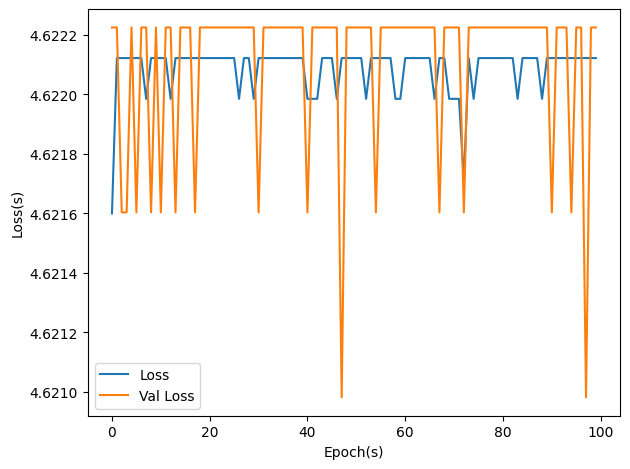

In [17]:
def loss_curve(losses):
    loss = losses['loss']
    val_loss = losses['val_loss']
    
    plt.plot(range(len(loss)), loss, label="Loss")
    plt.plot(range(len(val_loss)), val_loss, label="Val Loss")
    
    plt.xlabel("Epoch(s)")
    plt.ylabel("Loss(s)")
    

    plt.tight_layout()
    plt.legend()
    plt.show()

loss_curve(history)